In [52]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [53]:
import cv2
import numpy as np
import glob
from skimage import io

width=100
height=100


Data=[]
Target=[]

# benign cancer
file_list = glob.glob(r'/content/drive/My Drive/DataSet/BUSI/benign/*.png')

for i in file_list:
  im=cv2.imread(i)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im=cv2.resize(im,(width,height))
  Data.append(im)
  Target.append(0)

file_list = glob.glob(r'/content/drive/My Drive/DataSet/BUSI/malignant/*.png')
# malignant cancer
for i in file_list:
  im=cv2.imread(i)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im=cv2.resize(im,(width,height))
  Data.append(im)
  Target.append(1)

file_list = glob.glob(r'/content/drive/My Drive/DataSet/BUSI/normal/*.png')
# malignant cancer
for i in file_list:
  im=cv2.imread(i)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  im=cv2.resize(im,(width,height))
  Data.append(im)
  Target.append(2)


In [56]:
from tensorflow.keras.utils import to_categorical
Final_Target = to_categorical(Target)

In [57]:
Final_Data=np.reshape(Data,(len(Data),height,width,1))

In [58]:
# CNN LSTM
from keras import layers
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D,SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.models import Model

myInput=layers.Input(shape=(height,width,1))
conv1=SeparableConv2D(64,3, activation='relu',padding='same')(myInput)
max1=MaxPooling2D(2)(conv1)
conv2=SeparableConv2D(64,3, activation='relu',padding='same')(max1)
max2=MaxPooling2D(2)(conv2)
Time1=layers.TimeDistributed(Flatten())(max2)
lstm1=LSTM(150)(Time1)
des1 =Dense(50, activation='relu')(lstm1)
Extract_Model = Model(myInput, des1)
des2 =Dense(20, activation='relu')(des1)
out_layer =Dense(3, activation='softmax')(des2)
model = Model(myInput, out_layer)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

verbose, epochs, batch_size = 1, 10, 32
model.fit(Final_Data,Final_Target, epochs=epochs, batch_size=batch_size, verbose=verbose)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 separable_conv2d_10 (Separa  (None, 100, 100, 64)     137       
 bleConv2D)                                                      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_11 (Separa  (None, 50, 50, 64)       4736      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                     

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=0.3, random_state=42)

In [60]:
from keras import layers
from keras.models import Model
from keras import optimizers, losses

#===============================================================================
# Prepare data

import numpy as np
X_train=np.array(X_train)

X_test=np.array(X_test)
X_train = X_train.reshape(len(X_train), width,height,1)

X_test = X_test.reshape(len(X_test), width,height,1)

x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = np.reshape(X_train, (len(X_train), 100, 100, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(X_test, (len(X_test), 100, 100, 1))  # adapt this if using `channels_first` image data format

In [61]:
# Create Layers + Model

input_img = layers.Input(shape=(100, 100, 1))  # adapt this if using `channels_first` image data format

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy)

#===============================================================================
# Train the Model

autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

#===============================================================================

Epoch 1/3
5/5 [==============================] - 55s 10s/step - loss: -13360.9189 - val_loss: -166100.3594
Epoch 2/3
5/5 [==============================] - 54s 11s/step - loss: -817749.9375 - val_loss: -5513126.5000
Epoch 3/3
5/5 [==============================] - 53s 10s/step - loss: -16822524.0000 - val_loss: -78495896.0000


8/8 [==============================] - 6s 752ms/step


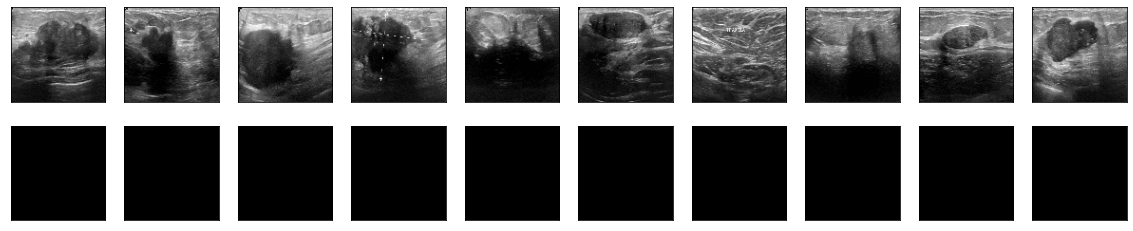

In [62]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()